Load up experiment & annotations

In [41]:
from classification.classification import classify_all
from preprocessing._chunk_preparation import merge_left_and_right_chunk
from visualization import plot_duration_histogram
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from data_reading.phyphox import read_experiment
from preprocessing._interpolation import align_data
from file_handling import get_sub_directories
from features._timeseries_feature_extraction import extract_timeseries_features
from preprocessing import segment_windows

from sklearn.preprocessing import StandardScaler

from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
experiment_dir_path = "../../data/phyphox/short recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)

sample_rate = 50
chunks = {"right": [], "left": []}
null_chunks = {"right": [], "left": []}
y_columns = ["start", "end", "label", "hand"]
y = pd.DataFrame(columns=y_columns)
#del experiment_dirs[1]
for dir in experiment_dirs:
    offsets = {}
    with open(dir + "/offset.txt") as f:
        for line in f:
           (key, val) = line.split(": ")
           offsets[key] = val

    data_frames = read_experiment(dir, offsets=offsets)
    data_frames = {key : align_data(data_frame, listening_rate=1000/sample_rate, reference_sensor=None) for key, data_frame in data_frames.items()}

    y_user = pd.read_csv(dir + "/annotations.tsv", delimiter="\t", header=None)
    hands = pd.read_csv(dir + "/hands.tsv", delimiter="\t", header=None)
    y_user = y_user.iloc[:, [3,5,8]]
    hands = hands.iloc[:, [8]]
    y_user = pd.concat([y_user, hands], axis=1)
    y_user.columns = y_columns
    y = pd.concat([y, y_user], axis=0)

    # iterate over the annotations and split the timeseries in chunks
    for key, df in data_frames.items():
        chunks[key] += [df.iloc[int(annotation["start"]*sample_rate):int(annotation["end"]*sample_rate)] for i, annotation in y_user.iterrows()]
        # null chunks are everything in between annotations
        null_chunks[key] += [df.iloc[int(annotation["end"]*sample_rate):int(y_user.iloc[i+1:i+2]["start"]*sample_rate)] for i, annotation in y_user.iterrows() if i < len(y_user)-1]

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


Preprocess data

No handles with labels found to put in legend.


Mean 4.74 +/- 8.01


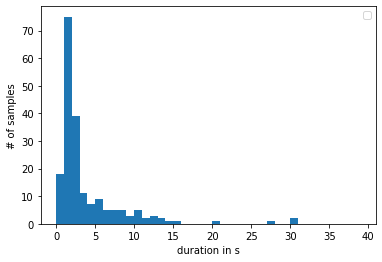

In [11]:
plot_duration_histogram(chunks["right"])

No handles with labels found to put in legend.


Mean 2.75 +/- 4.16


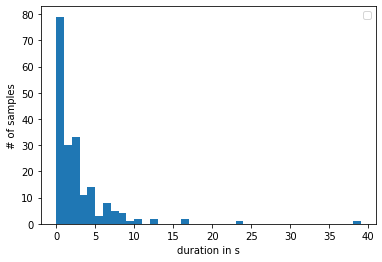

In [12]:
plot_duration_histogram(null_chunks["right"])

In [42]:
# append the activity label (as int) and the action id to the dataframe
# we need to do this to be able to extract time series features later

labels = y.loc[:, "label"].unique()
label_ids = { l: i for l,i in zip(labels, range(0,len(labels))) }

# list of tuples (left chunk, right chunk)
chunks_two_handed = []
# list of chunks
chunks_one_handed = []

y = y.replace(label_ids)


for i, cl in zip(range(len(y)), y.iterrows()):
    label_id = int(cl[1]["label"])
    action_id = i
    two_handed_chunk = []
    for hand, chunk_list in chunks.items():
        c = chunk_list[i]
        chunk_hand = cl[1]["hand"]
        two_handed_chunk.append(c)
        one_handed_chunk = c
        one_handed_chunk["action_id"] = action_id
        if chunk_hand == hand:
            #c["activity"] = label_id
            chunks_one_handed.append(one_handed_chunk)
    two_handed_chunk = merge_left_and_right_chunk(two_handed_chunk[0], two_handed_chunk[1], action_id)
    chunks_two_handed.append(two_handed_chunk)

labels = y.loc[:, "label"].squeeze()

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Feature extraction for 2 handed activities

In [19]:
window_size = 100

In [20]:
# prepare null chunks
null_class_chunks = []

# TODO: assert that this list is disjoint to the list of action ids from activities
null_action_ids = range(len(chunks_two_handed),len(chunks_two_handed)+len(null_chunks["right"]))
for c_r, c_l, action_id in zip(null_chunks["right"], null_chunks["left"], null_action_ids):
    if len(c_l):
        c_both = merge_left_and_right_chunk(c_l, c_r, action_id)
        null_class_chunks.append(c_both)

In [43]:
chunks_two_handed[1]

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
index,,,,,,,,,,,,,,,,,,,
00:00:17.371876,1.678234,-0.385590,2.444231,-0.148088,-0.007720,-0.094233,7.183780,3.584708,5.127371,1,0.389638,5.816172,-2.172924,-0.744250,-0.271157,0.016168,0.880700,-6.963841,-6.628070
00:00:17.391876,1.293325,-0.461773,2.317102,-0.153581,-0.004816,-0.116556,7.221034,3.612889,5.472194,1,0.952562,6.062816,-3.162986,-0.670069,-0.253052,-0.025896,0.551415,-6.669481,-6.942859
00:00:17.411876,0.696774,-0.614548,1.799734,-0.167420,-0.125314,-0.134282,7.455857,3.566362,5.505060,1,1.112585,5.190738,-3.670977,-0.642897,-0.426769,0.024512,0.297039,-6.562075,-7.246974
00:00:17.431876,0.545817,-0.819574,1.187929,-0.188715,-0.099840,-0.134046,7.247856,3.382734,5.499915,1,0.210383,3.508767,-2.630165,-0.607713,-0.627017,0.133036,0.012069,-6.508614,-7.254384
00:00:17.451876,0.759853,-0.319140,1.441072,-0.207124,-0.069299,-0.133849,6.962696,3.332871,5.582275,1,-1.359851,1.616434,-1.392325,-0.514140,-0.478037,0.235057,-0.315703,-6.343592,-7.524080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:20.171876,-0.042447,-0.771684,0.281490,-0.851658,1.282626,0.255117,6.372936,3.475034,7.483061,1,-1.136666,-0.290002,2.111803,0.737139,-1.567052,-2.073590,2.426433,-4.641074,6.262738
00:00:20.191876,0.170004,-0.578873,0.453902,-0.806168,1.704135,0.196419,6.551678,2.899764,7.944680,1,-1.071406,0.590055,1.279976,0.830864,-1.687337,-2.042473,3.367110,-4.986716,5.815970
00:00:20.211876,0.444108,-0.548059,0.434436,-0.774469,1.979230,0.138696,6.130173,2.883249,7.734406,1,-0.903062,1.055929,0.608612,0.887871,-1.750852,-2.025979,4.274697,-5.369520,5.889837


## Classification step 1: OCD activities vs null class samples

In [44]:
# new label id for ocd activities
labels_ocd_acts = pd.Series([labels.max()+2] * len(chunks_two_handed))
chunks_ocd_activities, labels_ocd_acts = segment_windows(chunks_two_handed, labels_ocd_acts.to_numpy(), window_size)

In [45]:
chunks_ocd_activities[9]

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
index,,,,,,,,,,,,,,,,,,,
00:00:55.071876,3.923415,-0.021167,2.410405,-0.846958,-0.089509,-0.848153,7.797354,4.939710,3.096656,"(12, 0)",-1.181379,-1.379792,-0.086926,-1.311344,-1.031302,3.863560,-10.761261,-0.476358,-0.217696
00:00:55.091876,3.667432,2.028885,2.184085,-0.820523,-0.201573,-0.851600,7.643625,4.782658,3.157552,"(12, 0)",-0.710007,-1.387507,-0.426239,-1.148625,-1.883786,4.028487,-10.533779,-0.636135,-0.038916
00:00:55.111876,3.501465,3.117181,1.862724,-0.888358,-0.179183,-0.874238,7.807304,5.034836,3.947567,"(12, 0)",-0.263616,-0.908945,-1.057948,-0.862900,-2.461839,4.231741,-10.583355,-0.098431,0.684331
00:00:55.131876,3.034164,2.664594,1.162598,-1.015222,-0.238962,-0.838532,8.145394,5.181580,5.003866,"(12, 0)",0.214666,-0.323165,-1.903629,-0.480070,-2.606999,4.263952,-10.093538,0.231600,2.409596
00:00:55.151876,2.559128,2.483424,0.894703,-1.070388,-0.223207,-0.840341,8.478120,4.958824,4.312678,"(12, 0)",0.316323,0.347684,-2.948922,-0.157906,-2.778839,4.188172,-9.463239,0.721326,2.794282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:56.971876,-0.044203,-2.366204,-0.551367,-0.011576,-0.383624,-0.435224,-0.976640,5.498099,8.050010,"(12, 0)",0.746382,0.082951,-1.868571,0.140956,-0.195111,-0.072327,-7.419907,5.291705,3.257505
00:00:56.991876,0.115154,-2.647137,-0.371380,-0.013983,-0.197336,-0.452871,-1.341138,6.001817,8.675451,"(12, 0)",0.701323,0.042937,-1.890516,0.120095,-0.246341,-0.054783,-7.648616,5.206905,3.219903
00:00:57.011876,-0.158698,-2.980621,-0.694457,-0.019248,-0.135588,-0.418989,-1.699935,5.569268,9.358429,"(12, 0)",0.687458,0.042881,-1.322084,0.110737,-0.198465,-0.037876,-7.889876,5.208258,3.145085


In [47]:
null_labels = pd.Series([labels.max()+1] * len(null_class_chunks))
null_class_chunks, null_labels = segment_windows(null_class_chunks, null_labels.to_numpy(), window_size)

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i in range(0, int(len(c) / window_size)):


In [48]:
null_class_chunks[9]

# TODO: assert that len(null_class_chunks.columns) == len(chunks_ocd_activities.columns)

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right,action_id
index,,,,,,,,,,,,,,,,,,,
00:01:17.904603,-2.222916,1.987714,-2.904807,0.133416,-0.524690,-0.022071,-0.192543,4.978603,9.114984,5.529011,1.512976,-0.007629,-0.573010,2.602648,1.793771,4.340628,10.132968,0.342523,"(214, 0)"
00:01:17.924603,-0.835716,1.465217,-3.104869,0.091004,0.009639,-0.131326,-0.491869,4.569183,9.342491,5.967993,2.251362,-0.165588,-0.591146,2.474429,1.759810,4.222457,11.017400,-0.255765,"(214, 0)"
00:01:17.944603,0.386532,0.876640,-3.124012,0.009114,0.111820,-0.147922,-0.202770,4.433944,9.167319,5.539351,2.356142,-0.538290,-0.541073,2.386359,1.712120,4.486829,11.811299,-0.918056,"(214, 0)"
00:01:17.964603,1.167841,0.345067,-3.119960,-0.020899,0.040331,-0.082060,-0.015292,4.481756,8.977159,4.721618,2.299096,-0.377313,-0.451794,2.411792,1.667145,5.021461,12.216050,-1.360152,"(214, 0)"
00:01:17.984603,1.317731,0.033327,-2.946616,0.002656,0.081222,0.004778,-0.292307,4.523532,8.821848,3.811376,2.284574,-0.535098,-0.350376,2.490039,1.629228,5.360187,11.983282,-1.466875,"(214, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:01:19.804603,-2.484587,1.085402,-2.403125,0.136510,-0.157179,-0.168429,0.549215,5.349926,8.535433,4.529094,0.693162,7.172179,-1.199503,-0.927373,1.038772,2.049645,9.468912,-0.447669,"(214, 0)"
00:01:19.824603,-3.820719,1.468288,-2.478323,0.128918,-0.175577,-0.173985,0.515930,5.326950,8.524165,3.862959,0.986688,5.496401,-1.232275,-0.880978,0.705783,1.952968,9.203836,-0.459236,"(214, 0)"
00:01:19.844603,-3.910064,1.332705,-2.838334,0.122995,-0.178140,-0.176172,0.511403,5.263986,8.546830,2.916409,0.778438,2.837919,-1.273592,-0.888493,0.396996,1.926755,8.999070,-0.500601,"(214, 0)"


### Feature extraction for OCD activities vs non-OCD activities

In [ ]:
null_classification_concat = pd.concat(chunks_ocd_activities + null_class_chunks).reset_index(drop=True)

features_two_handed_null_test = extract_timeseries_features(null_classification_concat)

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
Feature Extraction:  20%|██        | 4/20 [01:03<05:47, 21.71s/it]

### Feature selection for OCD activities vs non-OCD activities

In [ ]:
labels_null_test = pd.concat([labels_ocd_acts, null_labels])

In [ ]:
labels_null_test

In [45]:
impute(features_two_handed_null_test)
X_two_handed_selected_null_test = select_features(features_two_handed_null_test, labels_null_test)
X_two_handed_selected_null_test

variable,"acceleration x__fft_coefficient__attr_""angle""__coeff_0","acceleration x_right__fft_coefficient__attr_""angle""__coeff_0",acceleration x__count_above__t_0,acceleration x__range_count__max_1000000000000.0__min_0,acceleration x__count_below__t_0,acceleration x__sum_values,acceleration x__mean,"acceleration x__fft_coefficient__attr_""real""__coeff_0",acceleration x__c3__lag_2,acceleration x__c3__lag_1,...,"gyroscope y__fft_coefficient__attr_""abs""__coeff_46","acceleration x_right__change_quantiles__f_agg_""mean""__isabs_True__qh_0.6__ql_0.0",gyroscope y__quantile__q_0.8,"acceleration y__fft_coefficient__attr_""angle""__coeff_46","linear_acceleration x_right__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","linear_acceleration x_right__fft_coefficient__attr_""abs""__coeff_28","acceleration x__fft_aggregated__aggtype_""skew""",acceleration x__approximate_entropy__m_2__r_0.1,"acceleration y__cwt_coefficients__coeff_9__w_20__widths_(2, 5, 10, 20)","gyroscope y__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2"
id,,,,,,,,,,,,,,,,,,,,,
"(1, 0)",0.0,180.0,0.98,98.0,0.02,541.527197,5.415272,541.527197,230.467941,244.504211,...,0.167654,0.342325,0.665740,175.630024,0.057218,3.729831,2.261602,0.486665,2.913877,0.024252
"(3, 0)",0.0,180.0,0.87,87.0,0.13,387.084869,3.870849,387.084869,119.762046,182.399939,...,0.869871,0.401577,0.794486,149.545652,0.006923,1.012465,1.942516,0.274377,9.860676,0.087458
"(4, 0)",0.0,0.0,0.99,99.0,0.01,465.945843,4.659458,465.945843,124.648375,138.858445,...,0.925489,0.243992,0.655019,123.912519,0.000648,1.043003,1.260729,0.281935,8.691534,0.012129
"(5, 0)",0.0,0.0,1.00,100.0,0.00,427.113248,4.271132,427.113248,96.150586,98.623656,...,0.121859,0.192719,-0.023710,155.898082,0.008843,2.704161,2.303529,0.497350,5.677821,0.006132
"(6, 0)",0.0,0.0,0.96,96.0,0.04,451.622587,4.516226,451.622587,156.810145,182.882140,...,2.042969,0.313243,0.557421,-6.516100,0.002147,0.413106,1.500807,0.232840,9.036224,0.002606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1000200, 0)",180.0,0.0,0.00,0.0,1.00,-291.921922,-2.919219,-291.921922,-33.401489,-39.112910,...,0.488078,0.114364,0.781245,173.512372,0.018466,2.337317,2.447228,0.368820,16.465729,0.042359
"(1000201, 0)",180.0,0.0,0.00,0.0,1.00,-256.770738,-2.567707,-256.770738,-24.474765,-26.975901,...,0.875443,0.570816,0.497309,-6.952378,0.013124,1.959615,2.184806,0.290973,14.973464,0.042796
"(1000202, 0)",180.0,0.0,0.00,0.0,1.00,-258.449116,-2.584491,-258.449116,-27.276070,-31.226589,...,1.411602,0.363291,0.444769,-9.275696,0.009308,1.507520,2.184609,0.329398,15.434518,0.039990


In [51]:
scaler = StandardScaler()
X_null_test = scaler.fit_transform(X_two_handed_selected_null_test)

Train models and score results

In [52]:
print("Two handed classification")
classify_all(X_null_test, labels_null_test)

Two handed classification
Logistic Regression: 0.97 +/- 0.03
LDA: 0.98 +/- 0.02
LinearSVC: 0.97 +/- 0.03
CART: 0.97 +/- 0.03
NB: 0.86 +/- 0.13


In [ ]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)


### Feature extraction for 2 handed classifier of activities against each other

In [4]:
pd.concat(chunks_two_handed).reset_index(drop=True)

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
0,1.678234,-0.385590,2.444231,-0.148088,-0.007720,-0.094233,7.183780,3.584708,5.127371,"(1, 0)",0.389638,5.816172,-2.172924,-0.744250,-0.271157,0.016168,0.880700,-6.963841,-6.628070
1,1.293325,-0.461773,2.317102,-0.153581,-0.004816,-0.116556,7.221034,3.612889,5.472194,"(1, 0)",0.952562,6.062816,-3.162986,-0.670069,-0.253052,-0.025896,0.551415,-6.669481,-6.942859
2,0.696774,-0.614548,1.799734,-0.167420,-0.125314,-0.134282,7.455857,3.566362,5.505060,"(1, 0)",1.112585,5.190738,-3.670977,-0.642897,-0.426769,0.024512,0.297039,-6.562075,-7.246974
3,0.545817,-0.819574,1.187929,-0.188715,-0.099840,-0.134046,7.247856,3.382734,5.499915,"(1, 0)",0.210383,3.508767,-2.630165,-0.607713,-0.627017,0.133036,0.012069,-6.508614,-7.254384
4,0.759853,-0.319140,1.441072,-0.207124,-0.069299,-0.133849,6.962696,3.332871,5.582275,"(1, 0)",-1.359851,1.616434,-1.392325,-0.514140,-0.478037,0.235057,-0.315703,-6.343592,-7.524080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42895,0.420264,-1.520919,1.745219,0.129853,0.526094,0.941656,5.181903,8.722942,0.377629,"(198, 0)",1.702139,-2.243742,1.232675,-0.266555,-0.926576,-0.687580,-1.433117,8.083695,2.528200
42896,0.699171,-1.990826,2.167595,0.180453,0.787079,0.959576,4.845384,8.098407,0.316823,"(198, 0)",2.080271,-2.421250,1.092142,-0.430902,-1.114891,-0.620706,-1.911077,7.579574,2.067366
42897,0.847830,-2.334667,2.403779,0.229753,0.932723,0.964566,4.410565,7.668537,0.156555,"(198, 0)",2.526943,-2.448590,1.171999,-0.659824,-1.216200,-0.575852,-2.117720,7.340430,2.054657
42898,0.810991,-2.718580,2.317236,0.273200,0.970142,0.952962,4.034741,7.368434,0.034566,"(198, 0)",2.996077,-2.646845,1.012847,-0.916916,-1.151133,-0.554383,-2.158807,7.008133,2.193577


In [ ]:
features_two_handed = extract_timeseries_features(pd.concat(chunks_two_handed).reset_index(drop=True))

In [6]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

variable,acceleration x__abs_energy,acceleration x__absolute_sum_of_changes,"acceleration x__agg_autocorrelation__f_agg_""mean""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""median""__maxlag_40","acceleration x__agg_autocorrelation__f_agg_""var""__maxlag_40","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","acceleration x__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""max""",...,linear_acceleration z_right__symmetry_looking__r_0.9500000000000001,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_1,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_2,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_3,linear_acceleration z_right__value_count__value_-1,linear_acceleration z_right__value_count__value_0,linear_acceleration z_right__value_count__value_1,linear_acceleration z_right__variance,linear_acceleration z_right__variance_larger_than_standard_deviation,linear_acceleration z_right__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
"(1, 0)",1912.544486,33.159242,-0.160048,-0.085034,0.217309,8.173156,8.232572,8.159980,-0.313964,8.481768,...,1.0,0.227340,2.195299,2.376313,0.0,0.0,0.0,3.691863,1.0,-3.847160
"(1, 1)",1694.569214,21.495797,-0.258646,-0.557672,0.515867,2.838194,2.056119,0.645979,0.706350,2.118955,...,1.0,0.421576,0.851399,0.462310,0.0,0.0,0.0,1.371367,1.0,-1.097858
"(2, 0)",216.712859,18.906774,-0.096425,-0.073417,0.092282,3.702593,2.413837,1.240833,0.594571,3.390941,...,1.0,0.410063,0.597641,0.674784,0.0,0.0,0.0,0.591563,0.0,-0.858561
"(3, 0)",851.287722,30.239879,-0.149573,-0.339712,0.170626,2.496877,0.632593,-0.338265,1.730374,1.391976,...,1.0,0.005795,-0.003970,-0.016620,0.0,0.0,0.0,0.399811,0.0,-1.125623
"(3, 1)",1955.692043,82.564330,-0.032945,-0.025405,0.100619,7.102053,3.861496,1.081462,7.478932,5.452291,...,1.0,-0.024833,-0.018717,-0.034982,0.0,0.0,0.0,1.710231,1.0,4.632921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(194, 0)",1270.308255,12.126886,-0.173483,-0.326611,0.331039,6.795790,6.103384,5.386495,0.248379,6.515048,...,1.0,-0.027575,-0.039353,-0.047447,0.0,0.0,0.0,0.364504,0.0,7.723238
"(195, 0)",2327.705542,19.895530,-0.215987,-0.392546,0.356344,5.695016,4.640919,3.336692,0.816706,5.037117,...,1.0,0.158099,0.618272,1.464310,0.0,0.0,0.0,2.093402,1.0,-38.686682
"(196, 0)",1652.589046,16.469508,-0.067918,-0.130333,0.077253,6.508614,5.090061,3.848248,1.036918,5.775362,...,1.0,-0.076229,-0.292366,-0.318585,0.0,0.0,0.0,0.499675,0.0,9.009616


### Feature selection for 2 handed classifier of activities against each other

In [7]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

variable,linear_acceleration x_right__number_crossing_m__m_0,"linear_acceleration z_right__fft_aggregated__aggtype_""centroid""","linear_acceleration x_right__fft_aggregated__aggtype_""centroid""","acceleration x_right__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_2__w_5__widths_(2, 5, 10, 20)",linear_acceleration x_right__partial_autocorrelation__lag_1,linear_acceleration x_right__autocorrelation__lag_1,linear_acceleration x_right__cid_ce__normalize_True,...,linear_acceleration z__number_crossing_m__m_-1,"linear_acceleration z_right__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.6","acceleration y__cwt_coefficients__coeff_13__w_20__widths_(2, 5, 10, 20)",linear_acceleration y_right__large_standard_deviation__r_0.30000000000000004,linear_acceleration z__symmetry_looking__r_0.1,acceleration x__variance_larger_than_standard_deviation,linear_acceleration z__large_standard_deviation__r_0.35000000000000003,linear_acceleration y__symmetry_looking__r_0.05,"acceleration x__fft_coefficient__attr_""angle""__coeff_0",linear_acceleration x__symmetry_looking__r_0.1
id,,,,,,,,,,,,,,,,,,,,,
"(1, 0)",8.0,5.764790,5.964218,0.841466,1.842397,1.920188,1.715359,0.800717,0.800717,4.064048,...,6.0,0.044624,15.092194,0.0,1.0,1.0,0.0,1.0,0.0,1.0
"(1, 1)",3.0,5.643660,4.975254,-4.075088,-9.753986,-13.719978,-5.133862,0.964666,0.964666,2.276323,...,10.0,0.048849,22.927947,1.0,1.0,1.0,0.0,1.0,0.0,1.0
"(2, 0)",2.0,4.561928,4.598258,2.290857,2.849970,3.307171,2.110916,0.958449,0.958449,1.017204,...,6.0,0.011753,13.259978,1.0,1.0,0.0,0.0,1.0,0.0,1.0
"(3, 0)",1.0,3.313166,4.849679,-0.144559,3.799184,4.569875,2.857670,0.951574,0.951574,1.509848,...,10.0,0.004638,21.889387,0.0,1.0,1.0,0.0,0.0,0.0,1.0
"(3, 1)",2.0,4.423368,2.525515,-5.946930,-4.897452,-7.121339,-2.078528,0.996498,0.996498,1.354626,...,8.0,0.041480,24.896247,0.0,1.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(194, 0)",4.0,7.265965,3.967199,-3.130830,-2.238852,-2.472498,-1.641522,0.984757,0.984757,1.473911,...,2.0,0.002950,36.830621,0.0,1.0,1.0,0.0,1.0,0.0,1.0
"(195, 0)",7.0,5.788983,5.879818,-2.392689,-5.552828,-6.214764,-4.369920,0.839344,0.839344,4.173187,...,6.0,0.086278,36.761450,0.0,1.0,1.0,0.0,0.0,0.0,1.0
"(196, 0)",4.0,7.153607,4.867968,-3.031965,-2.105729,-2.180838,-1.644336,0.963945,0.963945,1.831981,...,2.0,0.001913,-19.040342,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [8]:
labels

(1, 0)      1
(1, 1)      1
(2, 0)      0
(3, 0)      1
(3, 1)      1
           ..
(194, 0)    9
(195, 0)    6
(196, 0)    9
(197, 0)    6
(198, 0)    9
Length: 858, dtype: int64

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [10]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

array([[-0.04518219, -0.64892871, -0.11627035, ..., -0.23801312,
         0.56568542, -0.24343225],
       [-1.20585038, -0.70055671, -0.64562914, ...,  4.20144903,
         0.56568542, -0.24343225],
       [-1.43798402, -1.16161152, -0.84742257, ...,  4.20144903,
         0.56568542, -0.24343225],
       ...,
       [-0.97371674, -0.05698844, -0.70305598, ..., -0.23801312,
        -1.76776695, -0.24343225],
       [-0.50944947, -0.43374807, -0.66864363, ..., -0.23801312,
         0.56568542, -0.24343225],
       [-0.27731583, -0.6871717 ,  0.25626235, ..., -0.23801312,
         0.56568542, -0.24343225]])

Train models and score results


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Two handed classification
Logistic Regression: 0.66 +/- 0.17
LDA: 0.67 +/- 0.15
LinearSVC: 0.63 +/- 0.18
CART: 0.55 +/- 0.15
NB: 0.49 +/- 0.16


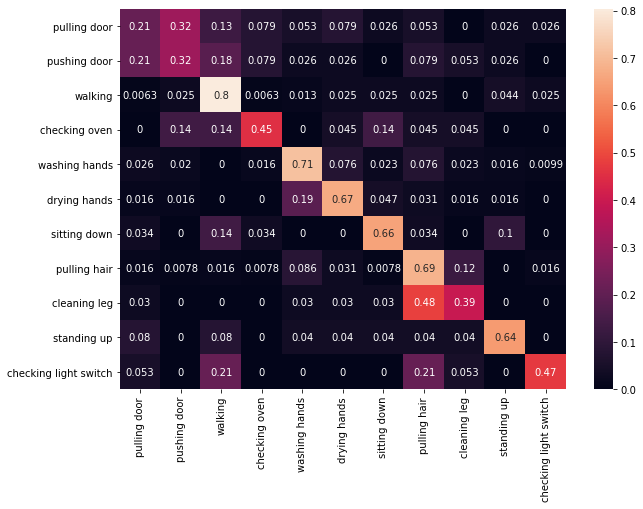

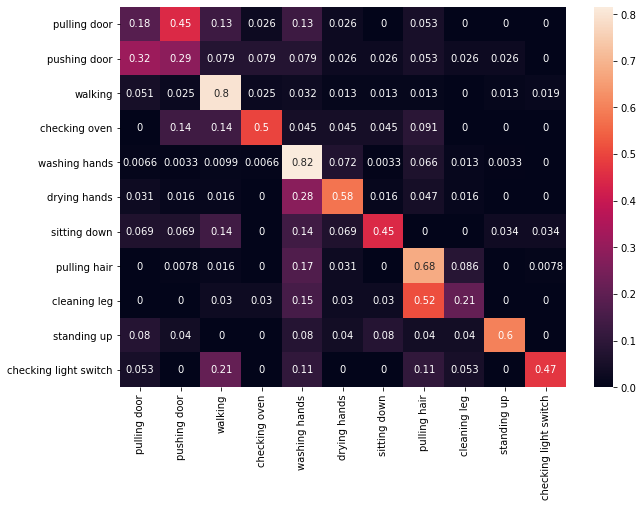

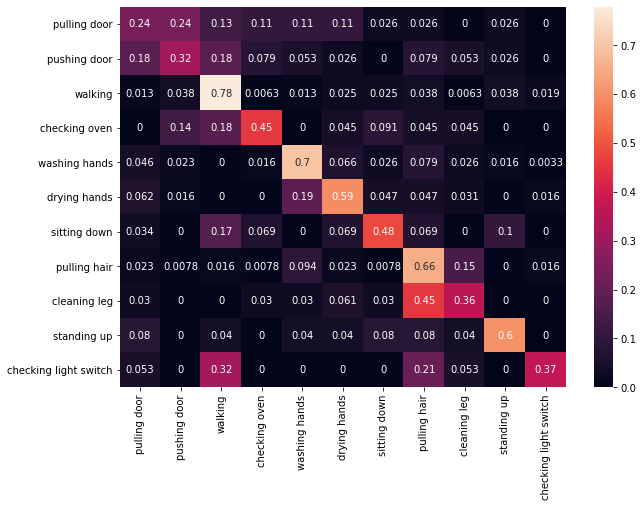

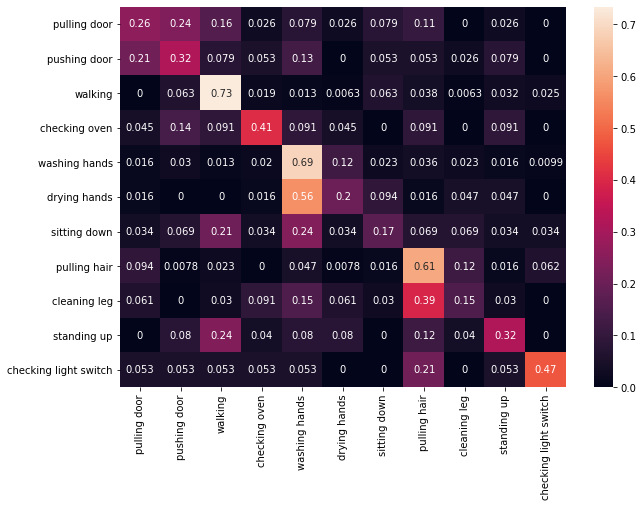

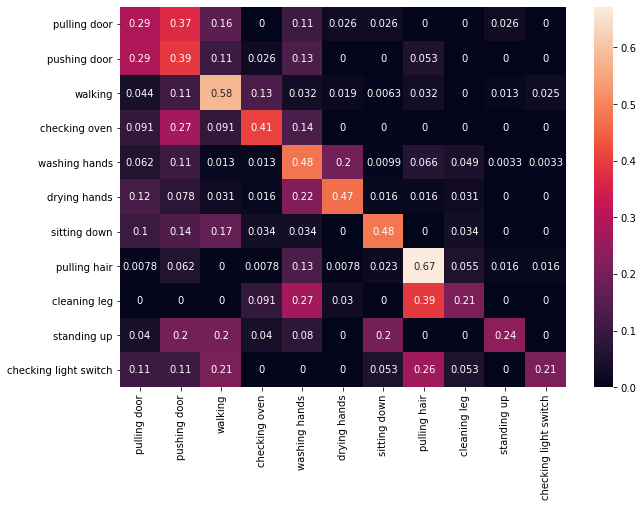

In [12]:
print("Two handed classification")
classify_all(X, labels, label_ids)